In [1]:
pip install pandas numpy scikit-learn pymc arviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

# For first-stage multinomial logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# For Bayesian neural network
import pymc as pm
import aesara.tensor as at
import aesara

# For data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For model diagnostics
import arviz as az

import pytensor.tensor as pt
import pytensor


# Read the data
data = pd.read_csv('/./Applications/Harvard/sophomore1/bst228/proj/final_data_full.csv')


# Display the first few rows
print(data.shape)
print(data.head)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


(27520, 79)
<bound method NDFrame.head of        Unnamed: 0   stay_id      primary_vp  caregiver_id  subject_id  \
0               1  30000646   phenylephrine          1349    12207593   
1               2  30001148   phenylephrine         39595    12980335   
2               3  30001446  norepinephrine         94503    16513856   
3               4  30002415   phenylephrine         78597    17921898   
4               5  30002548   phenylephrine         96640    14311522   
...           ...       ...             ...           ...         ...   
27515       27516  39997710  norepinephrine         49246    19391125   
27516       27517  39998012  norepinephrine         76512    17874908   
27517       27518  39998871  norepinephrine         97837    15954569   
27518       27519  39999230  norepinephrine         52316    13651601   
27519       27520  39999552   phenylephrine         87240    11256534   

      admission_type language marital_status  hospital_expire_flag  mortality  \


In [3]:
print(data.columns)
# Fill missing numerical values with mean
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].mean())

# Fill missing categorical values with mode
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])

Index(['Unnamed: 0', 'stay_id', 'primary_vp', 'caregiver_id', 'subject_id',
       'admission_type', 'language', 'marital_status', 'hospital_expire_flag',
       'mortality', 'los_days', 'hospital_free_days', 'gender', 'anchor_age',
       'mean_value_HeartRate', 'mean_value_SBP', 'mean_value_DBP',
       'mean_value_MAP', 'mean_value_RespRate', 'mean_value_SpO2',
       'mean_value_Temperature', 'min_value_HeartRate', 'min_value_SBP',
       'min_value_DBP', 'min_value_MAP', 'min_value_RespRate',
       'min_value_SpO2', 'min_value_Temperature', 'max_value_HeartRate',
       'max_value_SBP', 'max_value_DBP', 'max_value_MAP', 'max_value_RespRate',
       'max_value_SpO2', 'max_value_Temperature', 'Lactate_mean',
       'Creatinine_mean', 'Glucose_mean', 'Potassium_mean', 'Sodium_mean',
       'Hemoglobin_mean', 'Lactate_min', 'Creatinine_min', 'Glucose_min',
       'Potassium_min', 'Sodium_min', 'Hemoglobin_min', 'Lactate_max',
       'Creatinine_max', 'Glucose_max', 'Potassium_max', '

## Preprocess

In [4]:
# First-stage target variable: vasopressor choice
first_stage_target = 'primary_vp'

# First-stage features: HHI and patient covariates
first_stage_features = ['hhi', 'gender', 'anchor_age', 'race_group'] + \
    [col for col in data.columns if col.startswith('mean_value_')] + \
    [col for col in data.columns if col.startswith('min_value_')] + \
    [col for col in data.columns if col.startswith('max_value_')] + \
    [col for col in data.columns if col.endswith('_mean')] + \
    [col for col in data.columns if col.endswith('_min')] + \
    [col for col in data.columns if col.endswith('_max')]

# Encode 'gender', 'race', and 'primary_vp' if they are not numeric
categorical_features = ['gender', 'race_group', 'primary_vp']

# Label encode the target variable for logistic regression
label_encoder = LabelEncoder()
data['primary_vp_encoded'] = label_encoder.fit_transform(data['primary_vp'])

X = data[first_stage_features]
y = data['primary_vp_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


# Identify numerical and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## First Stage IV Estiamtion

In [5]:
data['primary_vp_encoded'] = label_encoder.fit_transform(data['primary_vp'])
print(data['primary_vp_encoded'])

0        1
1        1
2        0
3        1
4        1
        ..
27515    0
27516    0
27517    0
27518    0
27519    1
Name: primary_vp_encoded, Length: 27520, dtype: int64


In [19]:
# First-stage multinomial logistic regression
first_stage_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000))
])

# Fit the model
first_stage_pipeline.fit(X_train, y_train)
probabilities = first_stage_pipeline.predict_proba(X)

# Add the probabilities to the data as new columns
data['p0'] = probabilities[:, 0]  # Probability for category 0
data['p1'] = probabilities[:, 1]  # Probability for category 1
data['p2'] = probabilities[:, 2]
assert all((data['p0'] + data['p1'] + data['p2']).round(6) == 1), "Probabilities do not sum to 1 for some rows."

print(data[['p0', 'p1', 'p2']].head())
# Predict the vasopressor choices on the entire dataset
data['predicted_treatment_encoded'] = first_stage_pipeline.predict(X)
data['predicted_treatment'] = label_encoder.inverse_transform(data['predicted_treatment_encoded'])
print("First stage acc: ", sum(data['predicted_treatment']==data['primary_vp'])/len(data['primary_vp']))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


         p0        p1        p2
0  0.488286  0.461376  0.050339
1  0.144316  0.802129  0.053555
2  0.491160  0.411652  0.097188
3  0.148950  0.801450  0.049600
4  0.275642  0.682968  0.041390
First stage acc:  0.6442223837209302


In [7]:
print(sum(data['predicted_treatment_encoded']==2))
print(sum(data['primary_vp_encoded']==2))


2213
2717


## Bayesian Neural Network

In [19]:
print(second_stage_features)

['stay_id', 'subject_id', 'admission_type', 'marital_status', 'hospital_expire_flag', 'los_days', 'hospital_free_days', 'gender', 'anchor_age', 'mean_value_HeartRate', 'mean_value_SBP', 'mean_value_DBP', 'mean_value_MAP', 'mean_value_RespRate', 'mean_value_SpO2', 'mean_value_Temperature', 'min_value_HeartRate', 'min_value_SBP', 'min_value_DBP', 'min_value_MAP', 'min_value_RespRate', 'min_value_SpO2', 'min_value_Temperature', 'max_value_HeartRate', 'max_value_SBP', 'max_value_DBP', 'max_value_MAP', 'max_value_RespRate', 'max_value_SpO2', 'max_value_Temperature', 'Lactate_mean', 'Creatinine_mean', 'Glucose_mean', 'Potassium_mean', 'Sodium_mean', 'Hemoglobin_mean', 'Lactate_min', 'Creatinine_min', 'Glucose_min', 'Potassium_min', 'Sodium_min', 'Hemoglobin_min', 'Lactate_max', 'Creatinine_max', 'Glucose_max', 'Potassium_max', 'Sodium_max', 'Hemoglobin_max', 'Lactate_first', 'Creatinine_first', 'Glucose_first', 'Potassium_first', 'Sodium_first', 'Hemoglobin_first', 'Lactate_last', 'Creatinin

In [20]:
second_stage_target = 'mortality'

# Update exclude_cols to include 'predicted_treatment'
exclude_cols = ['primary_vp', 'primary_vp_encoded', 'discharge_location', 'discharge_status', 'mortality', 'caregiver_id', 'predicted_treatment']

# Define second_stage_features without duplicates
second_stage_features = [col for col in data.columns if col not in exclude_cols]

# Ensure 'predicted_treatment' is only included once
second_stage_features = list(dict.fromkeys(second_stage_features))

# Identify categorical features
categorical_features_second = data[second_stage_features].select_dtypes(include=['object']).columns.tolist()

# Convert categorical variables to category dtype
for col in categorical_features_second:
    data[col] = data[col].astype('category')

# Prepare the data for the second stage
X_second = data[second_stage_features]
y_second = data[second_stage_target]
print(X_second.shape)
numeric_features_second = X_second.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features_second = X_second.select_dtypes(include=['category']).columns.tolist()

# Preprocessing pipelines
numeric_transformer_second = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer_second = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor_second = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_second, numeric_features_second),
        ('cat', categorical_transformer_second, categorical_features_second)
    ])

# Apply preprocessing
X_second_processed = preprocessor_second.fit_transform(X_second)


# # Apply Ordinal Encoding to categorical features
# ordinal_encoder = OrdinalEncoder()
# X_second[categorical_features_second] = ordinal_encoder.fit_transform(X_second[categorical_features_second])

# # Preprocessing pipeline for numeric features
# numeric_transformer_second = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# preprocessor_second = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer_second, numeric_features_second)
#     ], remainder='passthrough')  

# # Apply preprocessing
# X_second_processed = preprocessor_second.fit_transform(X_second)
# print(X_second_processed.shape)

(27520, 79)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [35]:
print(y_second.shape)

(27520,)


In [31]:
print(X_second_processed.columns)

print(X_second_processed['p1'])

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## Spike and Slab

In [18]:
import pandas as pd

# Save X_second_processed to a CSV file
pd.DataFrame(X_second_processed).to_csv('X_second_processed.csv', index=False, header=False)
print("X_second_processed saved to 'X_second_processed.csv'")

# Save y_second to a CSV file
pd.DataFrame(y_second).to_csv('y_second.csv', index=False, header=False)
print("y_second saved to 'y_second.csv'")


X_second_processed saved to 'X_second_processed.csv'
y_second saved to 'y_second.csv'


In [9]:
# Imports
import pymc as pm
import pytensor.tensor as pt
import pytensor

X_shared = pytensor.shared(X_second_processed.astype(np.float32))
y_shared = pytensor.shared(y_second.values.astype(np.int8))

# Define the neural network architecture
n_input = X_second_processed.shape[1]
n_hidden = 10
n_output = 1

with pm.Model() as neural_network:
    # Hyperparameters for spike-and-slab prior
    pi = pm.Beta('pi', alpha=1, beta=4)
    tau = pm.HalfCauchy('tau', beta=1)
    
    # Weights and inclusion indicators for input to hidden layer
    w1 = pm.Normal('w1', mu=0, sigma=tau, shape=(n_input, n_hidden))
    print("Type of w1:", type(w1))
    z1 = pm.Bernoulli('z1', p=pi, shape=(n_input, n_hidden))
    
    # Combine weights and indicators
    w1_combined = w1 * z1
    
    print("Type of X_shared:", type(X_shared))
    print("Shape of X_shared:", X_shared.get_value().shape)

    print("Type of w1_combined:", type(w1_combined))
    if hasattr(w1_combined, 'shape'):
        print("Shape of w1_combined:", w1_combined.shape)
    else:
        print("w1_combined does not have a shape attribute")

    # Bias for hidden layer
    b1 = pm.Normal('b1', mu=0, sigma=1, shape=(n_hidden,))
    
    # Hidden layer
    hidden_pre = pt.dot(X_shared, w1_combined) + b1
    h1 = pt.maximum(hidden_pre, 0)  # ReLU activation
    
    # Weights and inclusion indicators for hidden to output layer
    w2 = pm.Normal('w2', mu=0, sigma=tau, shape=(n_hidden, n_output))
    z2 = pm.Bernoulli('z2', p=pi, shape=(n_hidden, n_output))
    w2_combined = w2 * z2
    
    # Bias for output layer
    b2 = pm.Normal('b2', mu=0, sigma=1, shape=(n_output,))
    
    # Output layer (logits)
    logits = pt.dot(h1, w2_combined) + b2

    # Sigmoid activation for binary outcome
    p = pm.Deterministic('p', pt.sigmoid(pt.flatten(logits)))
    
    # Likelihood (Bernoulli for binary outcome)
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_shared)
    
    # Posterior Sampling
    trace = pm.sample(1000, tune=1000, chains=4, cores=4, target_accept=0.9)


Type of w1: <class 'pytensor.tensor.variable.TensorVariable'>
Type of X_shared: <class 'pytensor.tensor.sharedvar.TensorSharedVariable'>
Shape of X_shared: (27520, 123)
Type of w1_combined: <class 'pytensor.tensor.variable.TensorVariable'>
Shape of w1_combined: Shape.0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [pi, tau, w1, b1, w2, b2]
>BinaryGibbsMe

Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114596 seconds.
There were 1080 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [45]:
# Save trace as file
az.to_netcdf(trace, "neural_network_trace.nc")


'neural_network_trace.nc'

In [10]:
print(type(X_shared))
print(type(w1_combined))
print("X_shared shape:", X_shared.get_value().shape)
print("w1_combined shape:", w1_combined.shape)
print("Type of n_input:", type(n_input))
print("Type of n_hidden:", type(n_hidden))



<class 'pytensor.tensor.sharedvar.TensorSharedVariable'>
<class 'pytensor.tensor.variable.TensorVariable'>
X_shared shape: (27520, 123)
w1_combined shape: Shape.0
Type of n_input: <class 'int'>
Type of n_hidden: <class 'int'>


## Diagnostics and Convergence Checks

In [13]:
pip install --upgrade arviz

Note: you may need to restart the kernel to use updated packages.


In [21]:
# Load the saved trace
trace = az.from_netcdf("/Applications/Harvard/sophomore1/bst228/proj/Data/mimic_res/neural_network_trace.nc")

# Print summary or inspect the trace to ensure it's loaded correctly
print(trace)


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


In [22]:
import arviz as az
print(az.__version__)

0.20.0


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
pi    0.018  0.009   0.003    0.035      0.001    0.000     298.0     414.0   
tau  22.608  9.745   8.307   40.513      3.726    2.756       6.0      23.0   

     r_hat  
pi    1.02  
tau   1.73  


NameError: name 'p' is not defined

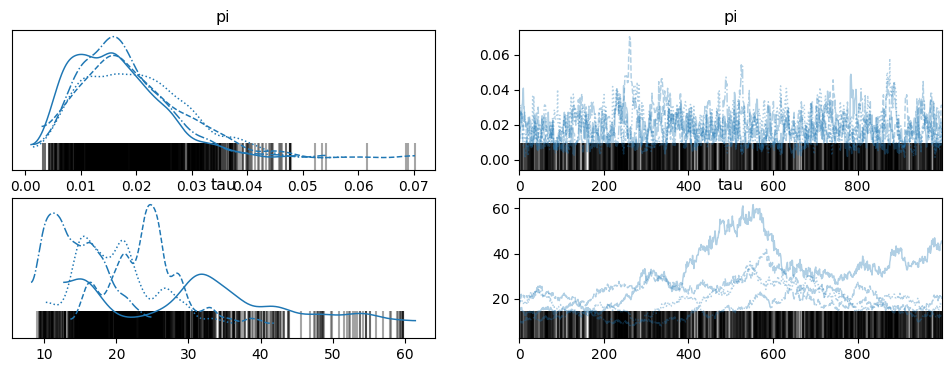

In [19]:
# Summary of the posterior
print(az.summary(trace, var_names=['pi', 'tau']))

# Trace plots
az.plot_trace(trace, var_names=['pi', 'tau'])

# Posterior predictive checks
with pm.Model() as neural_network:
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_shared)
    ppc = pm.sample_posterior_predictive(trace, var_names=['y_obs'])

array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

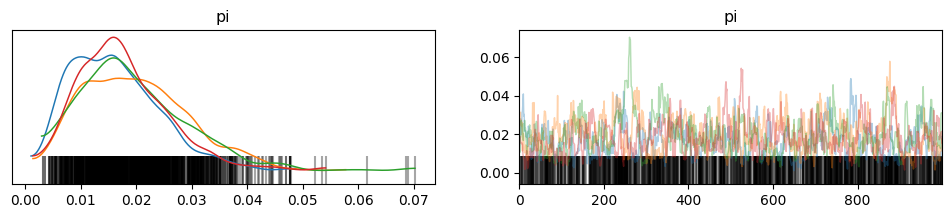

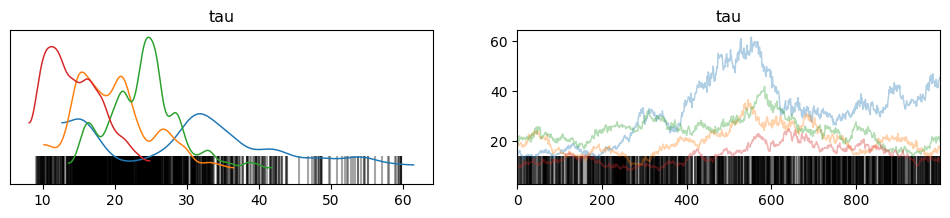

In [23]:
az.plot_trace(trace, var_names=['pi'], compact=False)
az.plot_trace(trace, var_names=['tau'], compact=False)


In [59]:
import arviz as az

posterior = trace.posterior

# Loop through each chain
for chain_id in posterior.chain.values:
    # Use a list for indexing to keep the chain dimension
    chain_data = posterior.isel(chain=[chain_id])
    print(f"Chain {chain_id} summary:")
    chain_summary = az.summary(chain_data, var_names=['pi', 'tau'], round_to=2)
    print(chain_summary)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Chain 0 summary:
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
pi    0.02   0.01    0.00     0.03       0.00     0.00     86.89    155.51   
tau  31.77  12.34   12.76    53.85       8.06     6.62      2.35     14.75   

     r_hat  
pi     NaN  
tau    NaN  
Chain 1 summary:
      mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
pi    0.02  0.01    0.00     0.04       0.00     0.00     80.75    109.29   
tau  20.00  5.26   10.49    29.38       3.08     2.44      3.18     22.28   

     r_hat  
pi     NaN  
tau    NaN  
Chain 2 summary:
      mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
pi    0.02  0.01    0.00     0.04       0.00     0.00     61.87     84.47   
tau  24.22  5.07   15.08    33.40       1.82     1.34      7.68     11.82   

     r_hat  
pi     NaN  
tau    NaN  
Chain 3 summary:
      mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
pi    0.02  0.01    0.01     0.03      

In [24]:
inference_data = pm.to_inference_data(trace)
if "posterior_predictive" in inference_data._groups:
    del inference_data.posterior_predictive

# Create a new posterior_predictive group
ppc_inference_data = az.from_dict(posterior_predictive={"y_obs": ppc["observed_data"]})

# Add the new posterior_predictive group
inference_data.add_groups({"posterior_predictive": ppc_inference_data.posterior_predictive})

# Verify the updated InferenceData
print(inference_data)

NameError: name 'ppc' is not defined

In [11]:
print(ppc)
print(inference_data)
print(inference_data.posterior_predictive)
print(list(inference_data.posterior_predictive.data_vars))
print(list(inference_data.observed_data.data_vars))
# Extract posterior_predictive data
posterior_predictive = inference_data.posterior_predictive

# Flatten the variable structure
posterior_predictive_flat = posterior_predictive.rename({('y_obs', 'y_obs'): 'y_obs'})

# Replace the group in the InferenceData object
inference_data.posterior_predictive = posterior_predictive_flat
print(list(inference_data.posterior_predictive.data_vars))

az.plot_ppc(inference_data, group="posterior", var_names=["y_obs"])
plt.show()


NameError: name 'ppc' is not defined

## Inference and Interpretation

In [64]:
# Extract the posterior samples of weights and inclusion probabilities
w1_samples = trace.posterior['w1'].stack(samples=("chain", "draw")).values  # Shape: (n_input, n_hidden, n_samples)
z1_samples = trace.posterior['z1'].stack(samples=("chain", "draw")).values  # Shape: (n_input, n_hidden, n_samples)

# Compute feature importance scores by averaging over hidden units and samples
feature_importance_scores = (np.abs(w1_samples) * z1_samples).mean(axis=(1, 2))  # Shape: (n_input,)

# Map back to feature names
feature_names = preprocessor_second.get_feature_names_out()
feature_importance = dict(zip(feature_names, feature_importance_scores))

# Convert feature importance values to a list
importance_values = np.array(list(feature_importance.values()))

# Compute the threshold
threshold = np.percentile(importance_values, 25)  # Top 25% features

# Select features with importance scores above the threshold
selected_features = [feature for feature, score in feature_importance.items() if score >= threshold]

features_to_remove = [
    'cat__discharge_status_Death',
    'cat__discharge_status_Home',
    'cat__discharge_status_Other',
    'num__Unnamed: 0',
    "num__hospital_expire_flag",
    'num__hospital_free_days'
]

# Remove the specified features from the selected_features list
selected_features = [feature for feature in selected_features if feature not in features_to_remove]

print("Selected Features for Final Neural Network:", len(selected_features))
print(selected_features)



Selected Features for Final Neural Network: 88
['num__stay_id', 'num__subject_id', 'num__los_days', 'num__anchor_age', 'num__mean_value_SBP', 'num__mean_value_RespRate', 'num__mean_value_SpO2', 'num__mean_value_Temperature', 'num__min_value_HeartRate', 'num__min_value_SBP', 'num__min_value_DBP', 'num__min_value_MAP', 'num__min_value_RespRate', 'num__min_value_SpO2', 'num__min_value_Temperature', 'num__max_value_RespRate', 'num__max_value_SpO2', 'num__max_value_Temperature', 'num__Lactate_mean', 'num__Creatinine_mean', 'num__Glucose_mean', 'num__Sodium_mean', 'num__Creatinine_min', 'num__Sodium_min', 'num__Hemoglobin_min', 'num__Lactate_max', 'num__Creatinine_max', 'num__Glucose_max', 'num__Potassium_max', 'num__Sodium_max', 'num__Lactate_first', 'num__Potassium_first', 'num__Hemoglobin_first', 'num__Glucose_last', 'num__Sodium_last', 'num__Hemoglobin_last', 'num__Creatinine_delta', 'num__Glucose_delta', 'num__hhi', 'num__p0', 'num__p1', 'num__p2', 'num__predicted_treatment_encoded', 'c

In [13]:
print(feature_names)

['num__Unnamed: 0' 'num__stay_id' 'num__subject_id'
 'num__hospital_expire_flag' 'num__los_days' 'num__hospital_free_days'
 'num__anchor_age' 'num__mean_value_HeartRate' 'num__mean_value_SBP'
 'num__mean_value_DBP' 'num__mean_value_MAP' 'num__mean_value_RespRate'
 'num__mean_value_SpO2' 'num__mean_value_Temperature'
 'num__min_value_HeartRate' 'num__min_value_SBP' 'num__min_value_DBP'
 'num__min_value_MAP' 'num__min_value_RespRate' 'num__min_value_SpO2'
 'num__min_value_Temperature' 'num__max_value_HeartRate'
 'num__max_value_SBP' 'num__max_value_DBP' 'num__max_value_MAP'
 'num__max_value_RespRate' 'num__max_value_SpO2'
 'num__max_value_Temperature' 'num__Lactate_mean' 'num__Creatinine_mean'
 'num__Glucose_mean' 'num__Potassium_mean' 'num__Sodium_mean'
 'num__Hemoglobin_mean' 'num__Lactate_min' 'num__Creatinine_min'
 'num__Glucose_min' 'num__Potassium_min' 'num__Sodium_min'
 'num__Hemoglobin_min' 'num__Lactate_max' 'num__Creatinine_max'
 'num__Glucose_max' 'num__Potassium_max' 'num__So

## Final Neural Network Using Selected Features

In [25]:
# Install Keras Tuner (if not already installed)
!pip install keras-tuner -q

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
import numpy as np
import shutil

# Prepare data with selected features
selected_indices = [list(feature_names).index(feat) for feat in selected_features]
p0_index = list(feature_names).index('num__p0')
p1_index = list(feature_names).index('num__p1')
p2_index = list(feature_names).index('num__p2')

final_indices = selected_indices + [p0_index, p1_index, p2_index]

X_final = X_second_processed[:, final_indices]

# Split into training and testing sets
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final,
    y_second,
    test_size=0.2,
    random_state=77
)

# Define a function to build the model, which Keras Tuner will use
def build_model(hp):
    model = Sequential()
    
    # Define the number of hidden layers and units per layer
    for i in range(hp.Int('num_layers', 1, 5)):
        if i == 0:
            # First layer (input layer)
            model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                            input_shape=(X_train_final.shape[1],)))
        else:
            # Subsequent layers
            model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)))
        
        # Optional Batch Normalization
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(BatchNormalization())
        
        # Activation function
        model.add(Activation(hp.Choice(f'activation_{i}', ['relu', 'tanh', 'sigmoid'])))
        
        # Optional Dropout
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


shutil.rmtree('my_dir/hyperparam_tuning', ignore_errors=True)

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,  # You can adjust this number
    executions_per_trial=1,
    directory='./my_dir',
    project_name='hyperparam_tuning'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(
    X_train_final,
    y_train_final,
    epochs=200,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(X_test_final, y_test_final)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = best_model.predict(X_test_final).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))


Trial 50 Complete [00h 00m 21s]
val_accuracy: 0.8176657557487488

Best val_accuracy So Far: 0.8219799995422363
Total elapsed time: 00h 28m 58s
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.8253 - loss: 0.3828
Test Accuracy: 0.8229
  1/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
              precision    recall  f1-score   support

    Survived       0.84      0.94      0.89      4154
        Died       0.71      0.46      0.56      1350

    accuracy                           0.82      5504
   macro avg       0.78      0.70      0.73      5504
weighted avg       0.81      0.82      0.81      5504



In [17]:
print(final_indices)

[8, 25, 69, 70, 83, 90, 96, 99, 102, 109, 110, 111, 66, 67, 68]


## Save. FinalResult

## Find Best Percentile & Regularization Comparison

Epoch 1/500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.7891 - loss: 0.4545 - val_accuracy: 0.8006 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.8040 - loss: 0.4200 - val_accuracy: 0.8004 - val_loss: 0.4130 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.8079 - loss: 0.4104 - val_accuracy: 0.7993 - val_loss: 0.4129 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.8138 - loss: 0.3995 - val_accuracy: 0.8115 - val_loss: 0.3988 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.8158 - loss: 0.3924 - val_accuracy: 0.8081 - val_loss: 0.3936 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.8210 - loss: 0.3868 - val_accuracy: 0.8113 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.8239 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.7865 - loss: 0.4573 - val_accuracy: 0.8020 - val_loss: 0.4239 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.8072 - loss: 0.4140 - val_accuracy: 0.7990 - val_loss: 0.4151 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.8074 - loss: 0.4122 - val_accuracy: 0.8002 - val_loss: 0.4102 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.8126 - loss: 0.4022 - val_accuracy: 0.8068 - val_loss: 0.4028 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.8151 - loss: 0.3958 - val_accuracy: 0.8072 - val_loss: 0.4012 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.8156 - loss: 0.3880 - val_accuracy: 0.8099 - val_loss: 0.3927 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.8201 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - accuracy: 0.7893 - loss: 0.4604 - val_accuracy: 0.8006 - val_loss: 0.4271 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.8071 - loss: 0.4207 - val_accuracy: 0.8020 - val_loss: 0.4141 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.8069 - loss: 0.4088 - val_accuracy: 0.8050 - val_loss: 0.4147 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.8127 - loss: 0.4008 - val_accuracy: 0.8038 - val_loss: 0.4077 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.8102 - loss: 0.4010 - val_accuracy: 0.8056 - val_loss: 0.3988 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.8240 - loss: 0.3793 - val_accuracy: 0.8086 - val_loss: 0.3956 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.8183 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - accuracy: 0.7917 - loss: 0.4542 - val_accuracy: 0.7986 - val_loss: 0.4238 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.8048 - loss: 0.4181 - val_accuracy: 0.8015 - val_loss: 0.4188 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.8081 - loss: 0.4092 - val_accuracy: 0.7988 - val_loss: 0.4224 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.8139 - loss: 0.3979 - val_accuracy: 0.8079 - val_loss: 0.4081 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.8162 - loss: 0.3978 - val_accuracy: 0.8093 - val_loss: 0.4020 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.8175 - loss: 0.3873 - val_accuracy: 0.8054 - val_loss: 0.3968 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.8208 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.7642 - loss: 0.4856 - val_accuracy: 0.7947 - val_loss: 0.4335 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.7981 - loss: 0.4336 - val_accuracy: 0.7954 - val_loss: 0.4290 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.7995 - loss: 0.4255 - val_accuracy: 0.7975 - val_loss: 0.4226 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.8052 - loss: 0.4095 - val_accuracy: 0.8034 - val_loss: 0.4160 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.8127 - loss: 0.4039 - val_accuracy: 0.8045 - val_loss: 0.4081 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.8140 - loss: 0.3942 - val_accuracy: 0.8090 - val_loss: 0.3999 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.8132 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.7769 - loss: 0.4722 - val_accuracy: 0.7870 - val_loss: 0.4361 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.7992 - loss: 0.4307 - val_accuracy: 0.8031 - val_loss: 0.4253 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.7989 - loss: 0.4248 - val_accuracy: 0.7981 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.8053 - loss: 0.4160 - val_accuracy: 0.8027 - val_loss: 0.4204 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.8095 - loss: 0.4017 - val_accuracy: 0.8061 - val_loss: 0.4059 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.8131 - loss: 0.3969 - val_accuracy: 0.8084 - val_loss: 0.4014 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.8168 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - accuracy: 0.7822 - loss: 0.4718 - val_accuracy: 0.7950 - val_loss: 0.4485 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.7890 - loss: 0.4442 - val_accuracy: 0.7995 - val_loss: 0.4391 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.8044 - loss: 0.4223 - val_accuracy: 0.8002 - val_loss: 0.4289 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.8001 - loss: 0.4248 - val_accuracy: 0.8045 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.8071 - loss: 0.4091 - val_accuracy: 0.8027 - val_loss: 0.4133 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.8098 - loss: 0.4022 - val_accuracy: 0.8086 - val_loss: 0.4088 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.8152 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step - accuracy: 0.7764 - loss: 0.4817 - val_accuracy: 0.7934 - val_loss: 0.4495 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.7880 - loss: 0.4478 - val_accuracy: 0.7981 - val_loss: 0.4364 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.7973 - loss: 0.4372 - val_accuracy: 0.8013 - val_loss: 0.4308 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.8027 - loss: 0.4287 - val_accuracy: 0.7988 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.8030 - loss: 0.4152 - val_accuracy: 0.8038 - val_loss: 0.4202 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.8092 - loss: 0.4074 - val_accuracy: 0.8065 - val_loss: 0.4119 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.8147 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.7838 - loss: 0.4761 - val_accuracy: 0.7900 - val_loss: 0.4539 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.7884 - loss: 0.4521 - val_accuracy: 0.7927 - val_loss: 0.4526 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.7922 - loss: 0.4470 - val_accuracy: 0.7954 - val_loss: 0.4431 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.7918 - loss: 0.4392 - val_accuracy: 0.7965 - val_loss: 0.4364 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.7951 - loss: 0.4299 - val_accuracy: 0.8013 - val_loss: 0.4332 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.8077 - loss: 0.4165 - val_accuracy: 0.8063 - val_loss: 0.4185 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.8084 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 607us/step - accuracy: 0.7659 - loss: 0.4940 - val_accuracy: 0.7886 - val_loss: 0.4533 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.7866 - loss: 0.4574 - val_accuracy: 0.7875 - val_loss: 0.4520 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.7845 - loss: 0.4542 - val_accuracy: 0.7916 - val_loss: 0.4441 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.8009 - loss: 0.4303 - val_accuracy: 0.7990 - val_loss: 0.4295 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.8029 - loss: 0.4197 - val_accuracy: 0.8009 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.8078 - loss: 0.4097 - val_accuracy: 0.8038 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.8049 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - accuracy: 0.7639 - loss: 0.4937 - val_accuracy: 0.7861 - val_loss: 0.4576 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.7873 - loss: 0.4545 - val_accuracy: 0.7922 - val_loss: 0.4503 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.7910 - loss: 0.4444 - val_accuracy: 0.7902 - val_loss: 0.4464 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.7907 - loss: 0.4381 - val_accuracy: 0.7979 - val_loss: 0.4391 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.7964 - loss: 0.4292 - val_accuracy: 0.8011 - val_loss: 0.4308 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.8027 - loss: 0.4181 - val_accuracy: 0.8034 - val_loss: 0.4225 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.8018 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step - accuracy: 0.7831 - loss: 0.4817 - val_accuracy: 0.7856 - val_loss: 0.4668 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.7873 - loss: 0.4626 - val_accuracy: 0.7838 - val_loss: 0.4638 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.7894 - loss: 0.4538 - val_accuracy: 0.7856 - val_loss: 0.4554 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.7980 - loss: 0.4404 - val_accuracy: 0.7981 - val_loss: 0.4410 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.7986 - loss: 0.4373 - val_accuracy: 0.8004 - val_loss: 0.4370 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.8025 - loss: 0.4269 - val_accuracy: 0.8034 - val_loss: 0.4355 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.8011 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.7800 - loss: 0.4817 - val_accuracy: 0.7811 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.7803 - loss: 0.4701 - val_accuracy: 0.7863 - val_loss: 0.4626 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.7839 - loss: 0.4665 - val_accuracy: 0.7904 - val_loss: 0.4566 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.7899 - loss: 0.4495 - val_accuracy: 0.7927 - val_loss: 0.4510 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.7900 - loss: 0.4442 - val_accuracy: 0.7972 - val_loss: 0.4448 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.8027 - loss: 0.4275 - val_accuracy: 0.7997 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.8025 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.7756 - loss: 0.4875 - val_accuracy: 0.7897 - val_loss: 0.4678 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.7884 - loss: 0.4605 - val_accuracy: 0.7866 - val_loss: 0.4630 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.7800 - loss: 0.4681 - val_accuracy: 0.7895 - val_loss: 0.4543 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.7899 - loss: 0.4471 - val_accuracy: 0.7922 - val_loss: 0.4566 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.7934 - loss: 0.4482 - val_accuracy: 0.7979 - val_loss: 0.4394 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.7994 - loss: 0.4355 - val_accuracy: 0.8020 - val_loss: 0.4365 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.8096 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - accuracy: 0.7627 - loss: 0.5030 - val_accuracy: 0.7875 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.7841 - loss: 0.4657 - val_accuracy: 0.7900 - val_loss: 0.4620 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.7875 - loss: 0.4593 - val_accuracy: 0.7938 - val_loss: 0.4558 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.7901 - loss: 0.4523 - val_accuracy: 0.7929 - val_loss: 0.4528 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.7963 - loss: 0.4421 - val_accuracy: 0.7975 - val_loss: 0.4460 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.7925 - loss: 0.4481 - val_accuracy: 0.7979 - val_loss: 0.4508 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.7943 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.7586 - loss: 0.5030 - val_accuracy: 0.7838 - val_loss: 0.4818 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.7797 - loss: 0.4757 - val_accuracy: 0.7891 - val_loss: 0.4703 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.7871 - loss: 0.4638 - val_accuracy: 0.7868 - val_loss: 0.4628 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.7897 - loss: 0.4546 - val_accuracy: 0.7893 - val_loss: 0.4574 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.7889 - loss: 0.4567 - val_accuracy: 0.7961 - val_loss: 0.4516 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.7981 - loss: 0.4409 - val_accuracy: 0.7941 - val_loss: 0.4502 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.8024 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - accuracy: 0.7740 - loss: 0.4974 - val_accuracy: 0.7779 - val_loss: 0.4850 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.7841 - loss: 0.4728 - val_accuracy: 0.7872 - val_loss: 0.4798 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.7864 - loss: 0.4676 - val_accuracy: 0.7866 - val_loss: 0.4796 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.7871 - loss: 0.4652 - val_accuracy: 0.7900 - val_loss: 0.4687 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.7795 - loss: 0.4689 - val_accuracy: 0.7909 - val_loss: 0.4643 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.7869 - loss: 0.4611 - val_accuracy: 0.7886 - val_loss: 0.4659 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.7925 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - accuracy: 0.7598 - loss: 0.5107 - val_accuracy: 0.7807 - val_loss: 0.4884 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.7689 - loss: 0.4905 - val_accuracy: 0.7786 - val_loss: 0.4843 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.7828 - loss: 0.4745 - val_accuracy: 0.7779 - val_loss: 0.4777 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.7841 - loss: 0.4728 - val_accuracy: 0.7822 - val_loss: 0.4763 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.7859 - loss: 0.4643 - val_accuracy: 0.7906 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.7860 - loss: 0.4618 - val_accuracy: 0.7891 - val_loss: 0.4631 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.7880 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step - accuracy: 0.7523 - loss: 0.5156 - val_accuracy: 0.7666 - val_loss: 0.5016 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.7700 - loss: 0.4948 - val_accuracy: 0.7663 - val_loss: 0.5000 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.7664 - loss: 0.5004 - val_accuracy: 0.7677 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.7705 - loss: 0.4955 - val_accuracy: 0.7707 - val_loss: 0.4992 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.7705 - loss: 0.4951 - val_accuracy: 0.7682 - val_loss: 0.4975 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.7710 - loss: 0.4921 - val_accuracy: 0.7684 - val_loss: 0.5057 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.7758 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step - accuracy: 0.7692 - loss: 0.5093 - val_accuracy: 0.7670 - val_loss: 0.5045 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.7705 - loss: 0.4959 - val_accuracy: 0.7698 - val_loss: 0.5033 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.7771 - loss: 0.4944 - val_accuracy: 0.7652 - val_loss: 0.5003 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.7745 - loss: 0.4956 - val_accuracy: 0.7702 - val_loss: 0.4997 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.7751 - loss: 0.4924 - val_accuracy: 0.7700 - val_loss: 0.4997 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.7708 - loss: 0.4972 - val_accuracy: 0.7695 - val_loss: 0.4975 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.7747 - loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step - accuracy: 0.7706 - loss: 0.5112 - val_accuracy: 0.7659 - val_loss: 0.5039 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.7659 - loss: 0.5067 - val_accuracy: 0.7650 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.7715 - loss: 0.4992 - val_accuracy: 0.7693 - val_loss: 0.5020 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.7760 - loss: 0.4912 - val_accuracy: 0.7702 - val_loss: 0.5005 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.7683 - loss: 0.5008 - val_accuracy: 0.7695 - val_loss: 0.5010 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.7722 - loss: 0.4962 - val_accuracy: 0.7704 - val_loss: 0.5019 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.7748 - loss: 

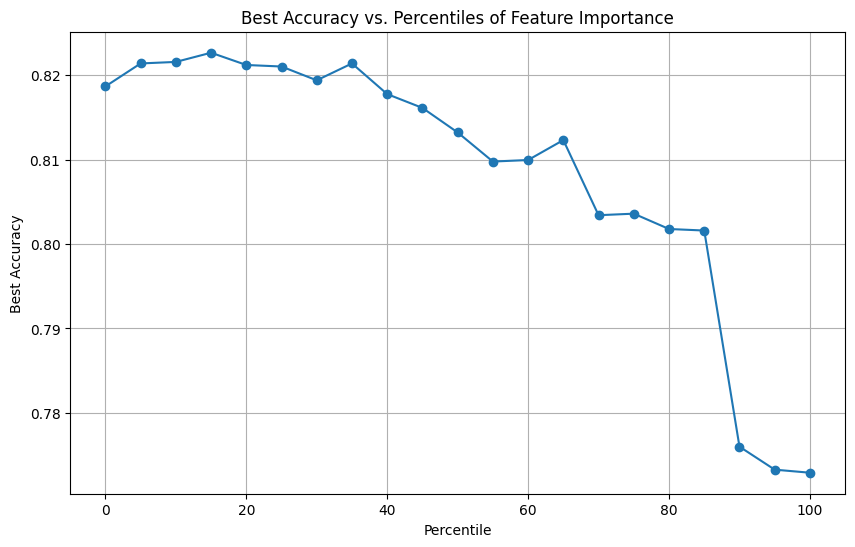

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Assume the following variables are defined from your previous code:
# data, y_second, preprocessor_second, feature_importance, best_hps, features_to_remove

# Convert feature importance values to numpy array
importance_values = np.array(list(feature_importance.values()))
feature_names = preprocessor_second.get_feature_names_out()

# Add the p0, p1, p2 features if needed
aux_features = ['num__p0', 'num__p1', 'num__p2']

# Define the percentiles from all features (0%) to 100% in increments of 5%
percentiles = np.arange(0, 101, 5)

best_accuracies = []
    
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for perc in percentiles:
    # Determine threshold
    threshold = np.percentile(importance_values, perc)
    
    # Select features above this threshold
    selected_features = [feature for feature, score in feature_importance.items() if score >= threshold]
    
    # Remove specified features
    selected_features = [feat for feat in selected_features if feat not in features_to_remove]
    
    # Add auxiliary features if they are available and not already included
    for aux_feat in aux_features:
        if aux_feat in feature_names and aux_feat not in selected_features:
            selected_features.append(aux_feat)
    
    # Prepare the data with selected features
    selected_indices = [list(feature_names).index(feat) for feat in selected_features]
    
    # Transform the entire dataset again
    X_second_processed_full = preprocessor_second.transform(data[second_stage_features])
    X_final = X_second_processed_full[:, selected_indices]
    
    # Split the data
    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
        X_final,
        y_second,
        test_size=0.2,
        random_state=77
    )

    # Build the model with the best hyperparameters
    model = build_model(best_hps)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

    # Retrain the model and capture the history
    history = model.fit(
        X_train_final,
        y_train_final,
        epochs=500,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_final, y_test_final, verbose=0)
    best_accuracies.append(accuracy)
    print(f"Percentile: {perc}, Features: {len(selected_features)}, Test Accuracy: {accuracy:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(percentiles, best_accuracies, marker='o')
plt.title('Best Accuracy vs. Percentiles of Feature Importance')
plt.xlabel('Percentile')
plt.ylabel('Best Accuracy')
plt.grid(True)
plt.show()

Color Palette (RGB values): [(0.24715576253545807, 0.49918708160096675, 0.5765599057376697), (0.2525741242463334, 0.5026993808626472, 0.5794992095664446), (0.25799248595720875, 0.5062116801243278, 0.5824385133952195), (0.2634108476680841, 0.5097239793860082, 0.5853778172239944), (0.2742475710898348, 0.5167485779093692, 0.5912564248815443), (0.27966593280071017, 0.5202608771710497, 0.5941957287103192), (0.28508429451158546, 0.5237731764327302, 0.5971350325390942), (0.2959210179333362, 0.5307977749560913, 0.603013640196644), (0.3013393796442115, 0.5343100742177718, 0.6059529440254189), (0.3067577413550869, 0.5378223734794522, 0.6088922478541938), (0.3121761030659622, 0.5413346727411328, 0.6118315516829688), (0.3230128264877129, 0.5483592712644937, 0.6177101593405185), (0.32843118819858824, 0.5518715705261742, 0.6206494631692935), (0.3338495499094636, 0.5553838697878547, 0.6235887669980685), (0.34468627333121427, 0.5624084683112157, 0.6294673746556183), (0.3501046350420896, 0.565920767572

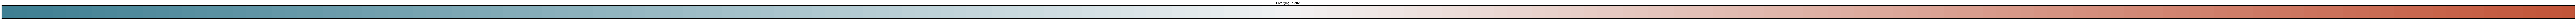

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the diverging palette
palette = sns.diverging_palette(220, 20, n=200)
color_palette = ['#D3D3D3', '#59858B', '#6A92C2', '#90BC95', '#A9CA9E', '#D7DEC0']

# Print the RGB values of the palette
print("Color Palette (RGB values):", palette)

# Optional: Convert RGB to Hex
def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

hex_palette = [rgb_to_hex(color) for color in palette]
print("Color Palette (Hex values):", hex_palette)

# Visualize the palette
sns.palplot(palette)
plt.title("Diverging Palette")
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


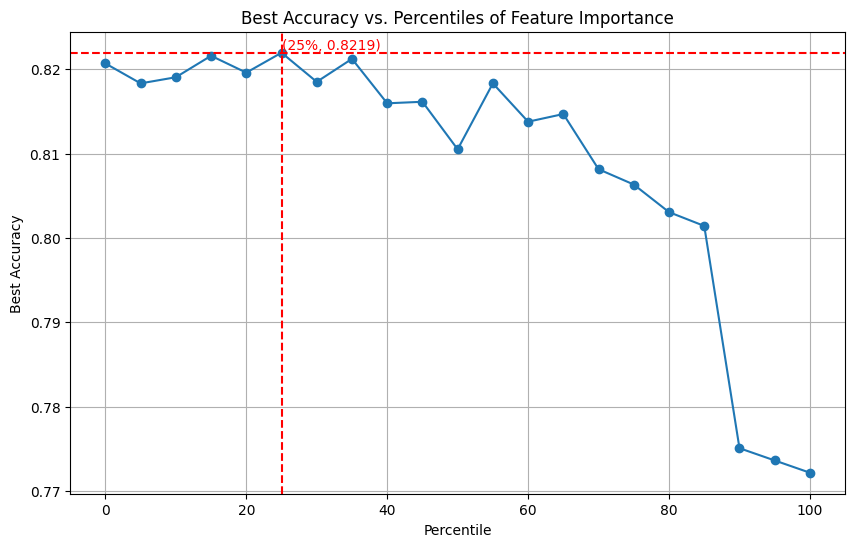

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have run the loop and have percentiles and best_accuracies arrays
# percentiles = ...
# best_accuracies = ...

# Find the index of the maximum accuracy
max_idx = np.argmax(best_accuracies)
max_percentile = percentiles[max_idx]
max_accuracy = best_accuracies[max_idx]

plt.figure(figsize=(10, 6))
plt.plot(percentiles, best_accuracies, marker='o', color=color_palette[2])

# Draw red dashed lines at the max accuracy point
plt.axvline(x=max_percentile, color=hex_palette[len(hex_palette)-1], linestyle='--')
plt.axhline(y=max_accuracy, color=hex_palette[len(hex_palette)-1], linestyle='--')

plt.title('Best Accuracy vs. Percentiles of Feature Importance')
plt.xlabel('Percentile')
plt.ylabel('Best Accuracy')
plt.grid(True)

# Optionally, add a text annotation to describe the point
plt.text(max_percentile, max_accuracy, f"({max_percentile}%, {max_accuracy:.4f})",
         ha='left', va='bottom', color=hex_palette[len(hex_palette)-1], fontsize=10)

plt.show()


Epoch 1/500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.7713 - loss: 0.4794 - val_accuracy: 0.7922 - val_loss: 0.4351 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.7935 - loss: 0.4381 - val_accuracy: 0.7990 - val_loss: 0.4262 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.8003 - loss: 0.4239 - val_accuracy: 0.8015 - val_loss: 0.4300 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.8016 - loss: 0.4185 - val_accuracy: 0.8045 - val_loss: 0.4130 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.8113 - loss: 0.4027 - val_accuracy: 0.8038 - val_loss: 0.4093 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.8152 - loss: 0.3924 - val_accuracy: 0.8070 - val_loss: 0.4021 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.8154 - loss: 

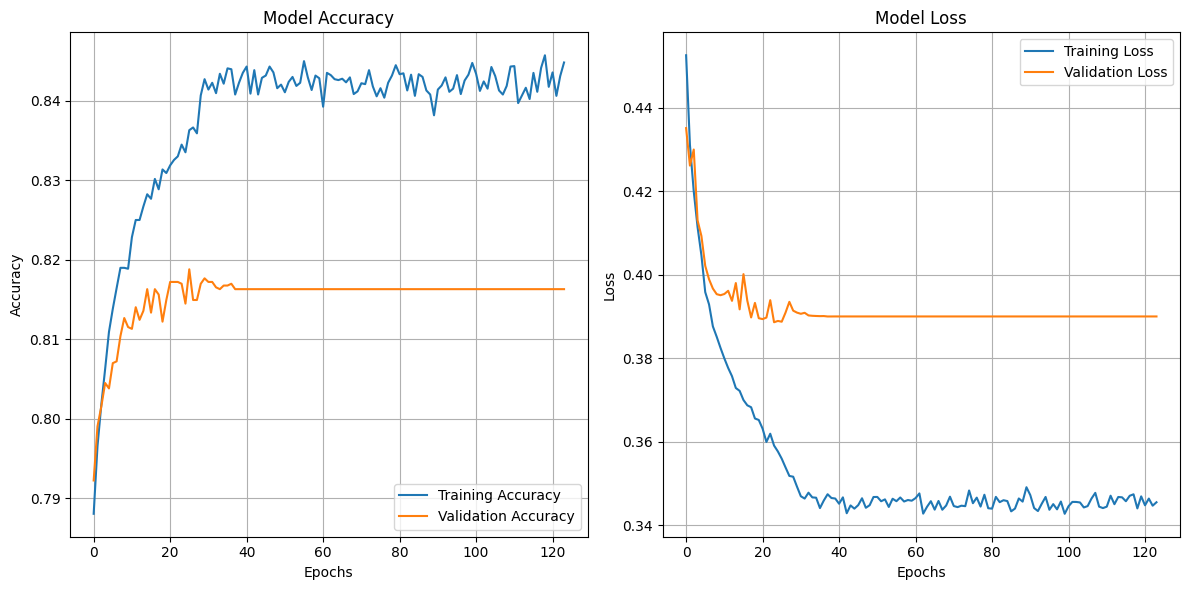

In [65]:
perc = 25

threshold = np.percentile(importance_values, perc)
    
# Select features above this threshold
selected_features = [feature for feature, score in feature_importance.items() if score >= threshold]
    
# Remove specified features
selected_features = [feat for feat in selected_features if feat not in features_to_remove]
    
# Add auxiliary features if they are available and not already included
for aux_feat in aux_features:
    if aux_feat in feature_names and aux_feat not in selected_features:
        selected_features.append(aux_feat)
    
# Prepare the data with selected features
selected_indices = [list(feature_names).index(feat) for feat in selected_features]
    
# Transform the entire dataset again
X_second_processed_full = preprocessor_second.transform(data[second_stage_features])
X_final = X_second_processed_full[:, selected_indices]
    
# Split the data
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final,
    y_second,
    test_size=0.2,
    random_state=77
)

# Build the model with the best hyperparameters
model = build_model(best_hps)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Retrain the model and capture the history
history = model.fit(
    X_train_final,
    y_train_final,
    epochs=500,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
    
# Evaluate the model
loss, accuracy = model.evaluate(X_test_final, y_test_final, verbose=0)
    
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test_final).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Now you can plot the training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()



Optimal Threshold (Highest Test Accuracy): 0.53
Test Accuracy at Optimal Threshold: 0.8229
              precision    recall  f1-score   support

    Survived       0.84      0.94      0.89      4154
        Died       0.72      0.45      0.55      1350

    accuracy                           0.82      5504
   macro avg       0.78      0.70      0.72      5504
weighted avg       0.81      0.82      0.81      5504



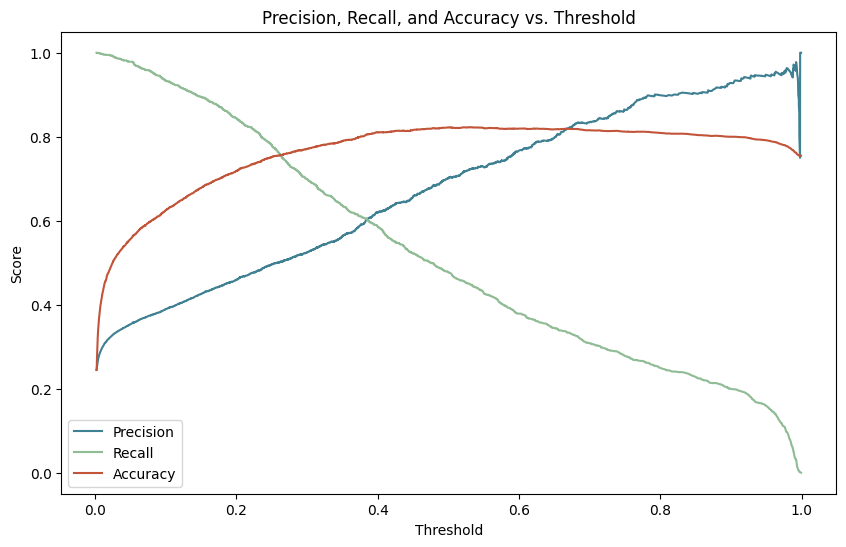

In [66]:
from sklearn.metrics import accuracy_score, precision_recall_curve

# Compute precision-recall pairs and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_final, y_pred_probs)

# Compute accuracy for each threshold
accuracies = []
for threshold in thresholds:
    y_pred = (y_pred_probs >= threshold).astype(int)
    accuracies.append(accuracy_score(y_test_final, y_pred))

# Find the optimal threshold based on maximum test accuracy
optimal_idx = np.argmax(accuracies)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (Highest Test Accuracy): {optimal_threshold:.2f}")
print(f"Test Accuracy at Optimal Threshold: {accuracies[optimal_idx]:.4f}")

# Use the optimal threshold for predictions
y_pred = (y_pred_probs >= optimal_threshold).astype(int)

# Print classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Plot precision, recall, and accuracy vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color = hex_palette[1])
plt.plot(thresholds, recall[:-1], label='Recall', color = color_palette[3])
plt.plot(thresholds, accuracies, label='Accuracy', color = hex_palette[len(hex_palette)-1])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()


In [47]:
def plot_confusion_matrix(cm, labels=['Survived', 'Died'], vmax=500, vmin=100, title='Confusion Matrix'):
    """
    Plots a confusion matrix with a diverging color palette.
    
    Args:
        cm (np.array): Confusion matrix (2D array).
        labels (list): List of labels for the confusion matrix axes. Default is None.
        vmax (int): Maximum value for color scaling. Default is 500.
        vmin (int): Minimum value for color scaling. Default is 100.
        title (str): Title of the confusion matrix plot. Default is 'Confusion Matrix'.
    """
    # Create a figure
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, 
                annot=True, 
                fmt='d',
                cmap=sns.diverging_palette(220, 20, n=200),
                vmin=vmin,
                vmax=vmax,
                center=(vmax + vmin) / 2,
                square=True,
                xticklabels=labels if labels else ['Class 0', 'Class 1'],
                yticklabels=labels if labels else ['Class 0', 'Class 1'])

    # Customize the plot
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Rotate tick labels for better readability
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

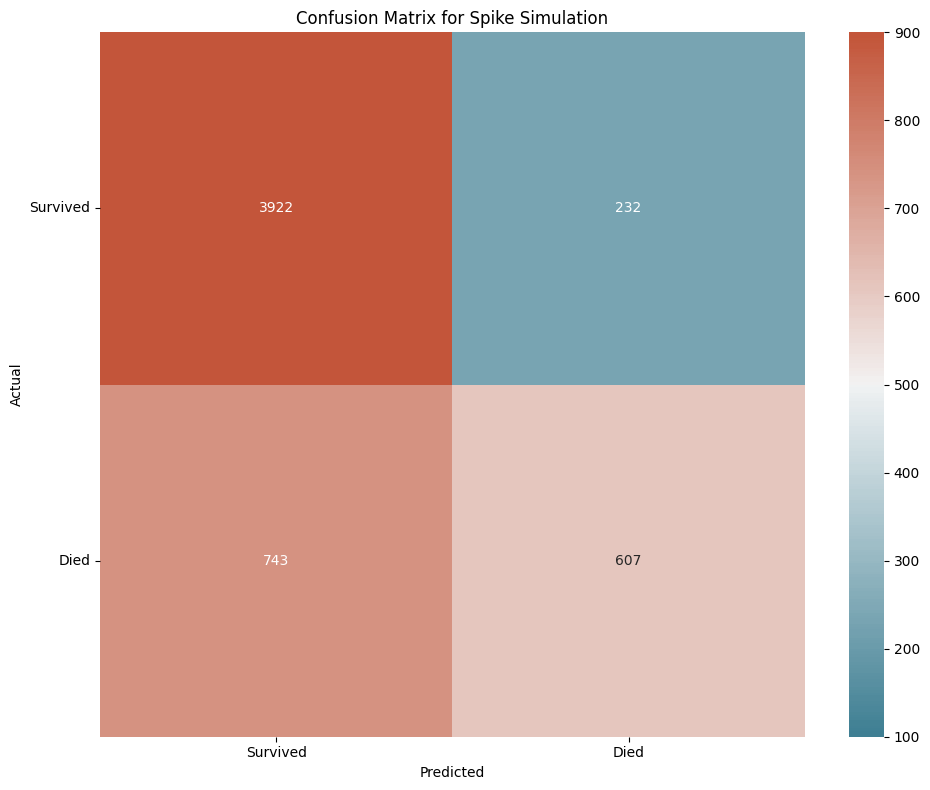

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap

# Confusion matrix
custom_palette = sns.diverging_palette(220, 10, n=20, as_cmap=False)
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_palette, N=200)
cm = confusion_matrix(y_test_final, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Survived', 'Died'])
#disp.plot(cmap=custom_cmap)
plot_confusion_matrix(cm, vmax=900, vmin=100, title="Confusion Matrix for Spike Simulation")

In [69]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Assuming binary classification and y_test_final, y_pred, y_pred_probs are known
precision_nn = precision_score(y_test_final, y_pred)
recall_nn = recall_score(y_test_final, y_pred)
f1_nn = f1_score(y_test_final, y_pred)
auc_nn = roc_auc_score(y_test_final, y_pred_probs)

print("Spike Neural Network Metrics:")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1 Score: {f1_nn:.4f}")
print(f"AUC: {auc_nn:.4f}")


Spike Neural Network Metrics:
Precision: 0.7235
Recall: 0.4496
F1 Score: 0.5546
AUC: 0.8531


## Save Results


In [95]:
import pandas as pd
import numpy as np

# 4. Make predictions on the entire dataset
y_pred_probs_full = model.predict(X_final).flatten()
y_pred_full = (y_pred_probs_full >= optimal_threshold).astype(int)

# 5. Append predictions to the original dataset
data_with_predictions = data.copy()
data_with_predictions['predicted_mortality_probability'] = y_pred_probs_full
data_with_predictions['predicted_mortality'] = y_pred_full

# 6. Save the updated dataset
data_with_predictions.to_csv('ALL_data_with_mortality_predictions.csv', index=False)


  1/860 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step

860/860 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


## LASSO Regularization

In [98]:
best_hps.values

{'num_layers': 3,
 'units_0': 96,
 'batch_norm_0': True,
 'activation_0': 'tanh',
 'dropout_0': 0.2,
 'optimizer': 'rmsprop',
 'units_1': 160,
 'batch_norm_1': True,
 'activation_1': 'relu',
 'dropout_1': 0.4,
 'units_2': 192,
 'batch_norm_2': False,
 'activation_2': 'relu',
 'dropout_2': 0.2,
 'units_3': 224,
 'batch_norm_3': False,
 'activation_3': 'sigmoid',
 'dropout_3': 0.4,
 'units_4': 128,
 'batch_norm_4': True,
 'activation_4': 'sigmoid',
 'dropout_4': 0.4}

Epoch 1/500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - accuracy: 0.7675 - loss: 1.4787 - val_accuracy: 0.7959 - val_loss: 0.5458 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.7960 - loss: 0.5348 - val_accuracy: 0.7959 - val_loss: 0.5151 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.7974 - loss: 0.5172 - val_accuracy: 0.7970 - val_loss: 0.5120 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.7977 - loss: 0.5050 - val_accuracy: 0.7943 - val_loss: 0.4988 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7928 - loss: 0.5032 - val_accuracy: 0.8006 - val_loss: 0.4896 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.8025 - loss: 0.4920 - val_accuracy: 0.7961 - val_loss: 0.4876 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.7999 - loss: 

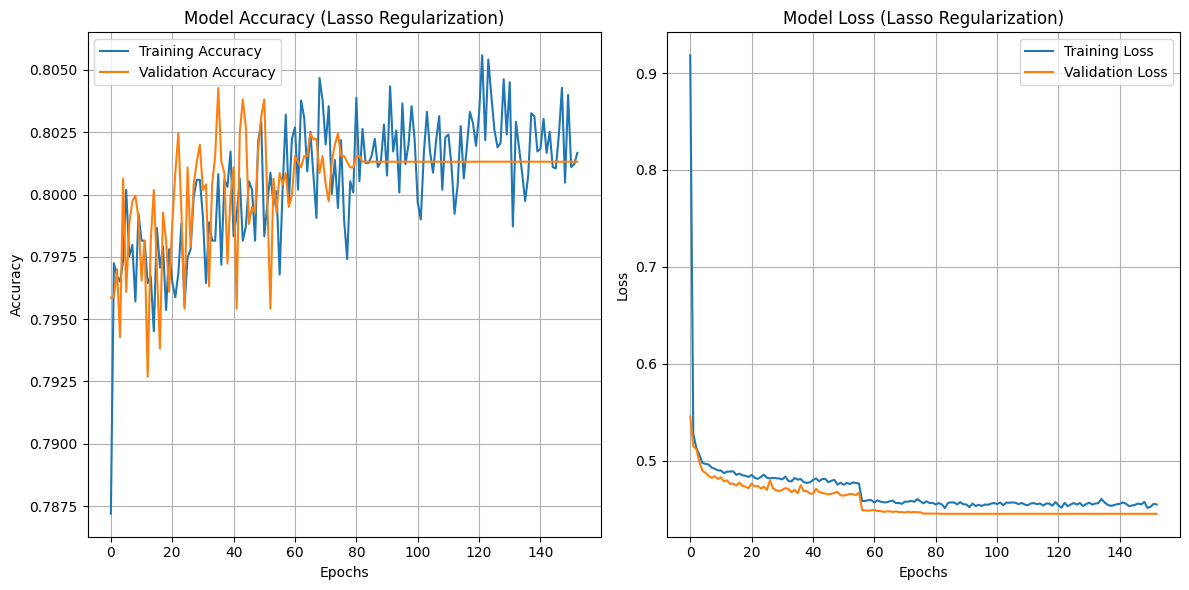

In [70]:
from tensorflow.keras import regularizers
perc = 0

threshold = np.percentile(importance_values, perc)
    
# Select features above this threshold
selected_features = [feature for feature, score in feature_importance.items() if score >= threshold]
    
# Remove specified features
selected_features = [feat for feat in selected_features if feat not in features_to_remove]
    
# Add auxiliary features if they are available and not already included
for aux_feat in aux_features:
    if aux_feat in feature_names and aux_feat not in selected_features:
        selected_features.append(aux_feat)
    
# Prepare the data with selected features
selected_indices = [list(feature_names).index(feat) for feat in selected_features]
    
# Transform the entire dataset again
X_second_processed_full = preprocessor_second.transform(data[second_stage_features])
X_final = X_second_processed_full[:, selected_indices]
    
# Split the data
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final,
    y_second,
    test_size=0.2,
    random_state=77
)

def build_model_with_lasso(hp, l1_lambda=1e-3):
    model = Sequential()
    num_layers = hp.get('num_layers')
    
    for i in range(num_layers):
        units = hp.get(f'units_{i}')
        activation = hp.get(f'activation_{i}')
        use_batch_norm = hp.get(f'batch_norm_{i}')
        dropout_rate = hp.get(f'dropout_{i}')
        
        if i == 0:
            model.add(Dense(units,
                            input_shape=(X_train_final.shape[1],),
                            kernel_regularizer=regularizers.l1(l1_lambda)))
        else:
            model.add(Dense(units, kernel_regularizer=regularizers.l1(l1_lambda)))
        
        if use_batch_norm:
            model.add(BatchNormalization())
        
        model.add(Activation(activation))
        
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = hp.get('optimizer')
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build the model using best_hps but with L1 regularization
model = build_model_with_lasso(best_hps, l1_lambda=1e-3)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Retrain the model and capture the history
history = model.fit(
    X_train_final,
    y_train_final,
    epochs=500,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_final, y_test_final, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test_final).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Lasso Regularization)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Lasso Regularization)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Optimal Threshold (Highest Test Accuracy): 0.55
Test Accuracy at Optimal Threshold: 0.8076
              precision    recall  f1-score   support

    Survived       0.81      0.96      0.88      4154
        Died       0.75      0.33      0.45      1350

    accuracy                           0.81      5504
   macro avg       0.78      0.64      0.67      5504
weighted avg       0.80      0.81      0.78      5504



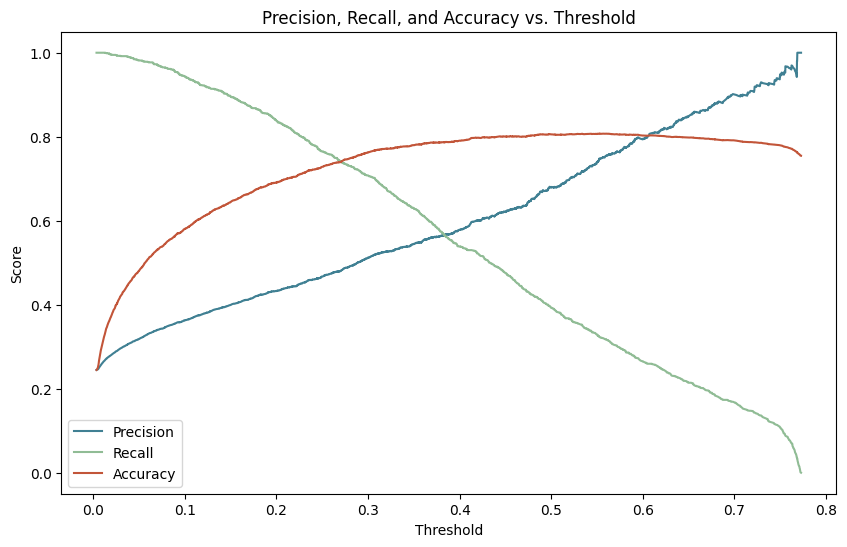

In [71]:
from sklearn.metrics import accuracy_score, precision_recall_curve

# Compute precision-recall pairs and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_final, y_pred_probs)

# Compute accuracy for each threshold
accuracies = []
for threshold in thresholds:
    y_pred = (y_pred_probs >= threshold).astype(int)
    accuracies.append(accuracy_score(y_test_final, y_pred))

# Find the optimal threshold based on maximum test accuracy
optimal_idx = np.argmax(accuracies)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (Highest Test Accuracy): {optimal_threshold:.2f}")
print(f"Test Accuracy at Optimal Threshold: {accuracies[optimal_idx]:.4f}")

# Use the optimal threshold for predictions
y_pred = (y_pred_probs >= optimal_threshold).astype(int)

# Print classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Plot precision, recall, and accuracy vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color = hex_palette[1])
plt.plot(thresholds, recall[:-1], label='Recall', color = color_palette[3])
plt.plot(thresholds, accuracies, label='Accuracy', color = hex_palette[len(hex_palette)-1])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()


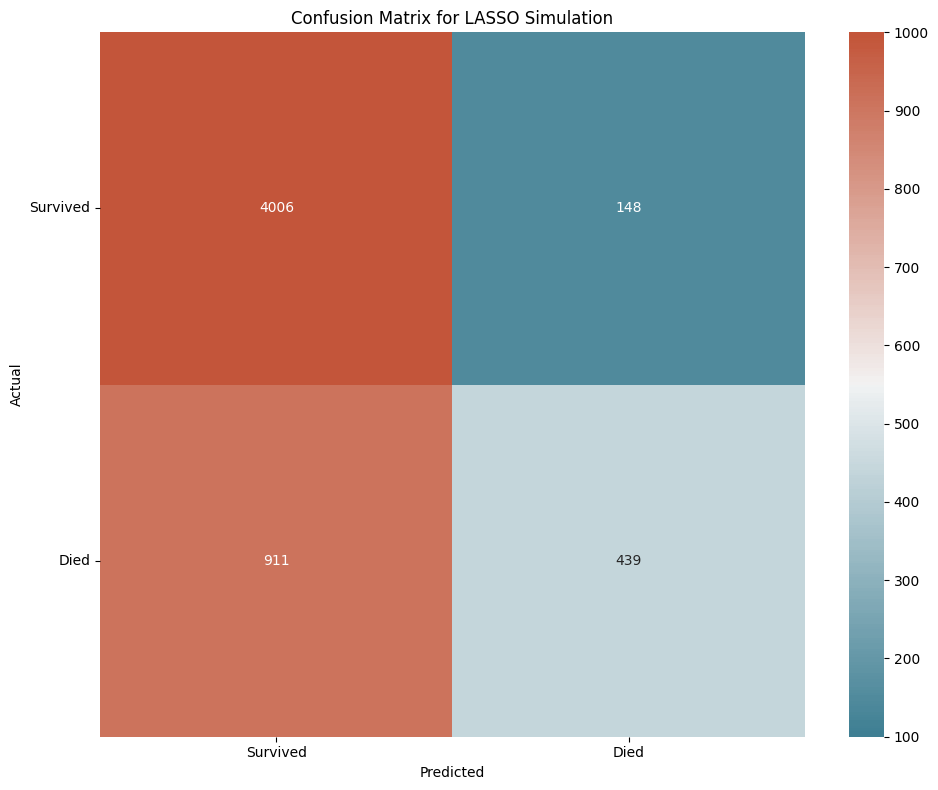

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test_final, y_pred)
plot_confusion_matrix(cm, vmax=1000, vmin=100, title="Confusion Matrix for LASSO Simulation")

In [116]:
# Predict on the entire dataset
y_pred_probs_full = model.predict(X_final).flatten()
y_pred_full = (y_pred_probs_full >= 0.5).astype(int)

# Append predictions to the original dataset
data_with_predictions = data.copy()
data_with_predictions['predicted_mortality_probability'] = y_pred_probs_full
data_with_predictions['predicted_mortality'] = y_pred_full

# Save the updated dataset
data_with_predictions.to_csv('LASSO_data_with_mortality_predictions.csv', index=False)

860/860 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Assuming binary classification and y_test_final, y_pred, y_pred_probs are known
precision_nn = precision_score(y_test_final, y_pred)
recall_nn = recall_score(y_test_final, y_pred)
f1_nn = f1_score(y_test_final, y_pred)
auc_nn = roc_auc_score(y_test_final, y_pred_probs)

print("LASSO Neural Network Metrics:")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1 Score: {f1_nn:.4f}")
print(f"AUC: {auc_nn:.4f}")


LASSO Neural Network Metrics:
Precision: 0.7479
Recall: 0.3252
F1 Score: 0.4533
AUC: 0.8316


## Baysian LASSO

In [74]:
import pandas as pd

# Suppose your ranking file is 'feature_ranking.csv' with columns 'Feature' and 'Importance_Score'
ranking_df = pd.read_csv('/Applications/Harvard/sophomore1/bst228/proj/Data/analysis_75percentile_results.csv')

# Convert this into a dictionary: { 'Feature_0': score, 'Feature_1': score, ... }
feature_importance = dict(zip(ranking_df['Feature'], ranking_df['Importance_Score']))
importance_values = np.array(list(feature_importance.values()))

# Compute a threshold, e.g., top 25% features
threshold = np.percentile(importance_values, 25)

# Select features that meet or exceed the threshold
selected_features = [
    feature for feature, score in feature_importance.items() 
    if score >= threshold
]

print("Selected Features for Final Neural Network:", len(selected_features))
print(selected_features)
# Map from Feature_0 -> actual_feature_name_0, etc.
mapping = {f"Feature_{i}": orig_name for i, orig_name in enumerate(feature_names)}

# Now translate your selected features:
selected_features_original = [mapping[f] for f in selected_features]
features_to_remove = [
    'cat__discharge_status_Death',
    'cat__discharge_status_Home',
    'cat__discharge_status_Other',
    'num__Unnamed: 0',
    "num__hospital_expire_flag",
    'num__hospital_free_days'
]

# Remove the specified features from the selected_features list
selected_features_original = [feature for feature in selected_features_original if feature not in features_to_remove]
print(selected_features_original)

Selected Features for Final Neural Network: 90
['Feature_5', 'Feature_3', 'Feature_4', 'Feature_74', 'Feature_14', 'Feature_22', 'Feature_83', 'Feature_10', 'Feature_72', 'Feature_16', 'Feature_24', 'Feature_15', 'Feature_88', 'Feature_19', 'Feature_70', 'Feature_8', 'Feature_23', 'Feature_6', 'Feature_9', 'Feature_99', 'Feature_59', 'Feature_69', 'Feature_41', 'Feature_20', 'Feature_89', 'Feature_64', 'Feature_37', 'Feature_30', 'Feature_7', 'Feature_101', 'Feature_40', 'Feature_96', 'Feature_35', 'Feature_77', 'Feature_91', 'Feature_97', 'Feature_26', 'Feature_11', 'Feature_43', 'Feature_25', 'Feature_94', 'Feature_38', 'Feature_65', 'Feature_92', 'Feature_98', 'Feature_79', 'Feature_12', 'Feature_52', 'Feature_110', 'Feature_84', 'Feature_55', 'Feature_112', 'Feature_100', 'Feature_66', 'Feature_49', 'Feature_85', 'Feature_17', 'Feature_67', 'Feature_39', 'Feature_76', 'Feature_46', 'Feature_42', 'Feature_13', 'Feature_113', 'Feature_90', 'Feature_81', 'Feature_80', 'Feature_86', 'F

Epoch 1/500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - accuracy: 0.7943 - loss: 0.4511 - val_accuracy: 0.7970 - val_loss: 0.4255 - learning_rate: 0.0010
Epoch 2/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.8058 - loss: 0.4154 - val_accuracy: 0.7954 - val_loss: 0.4155 - learning_rate: 0.0010
Epoch 3/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.8016 - loss: 0.4155 - val_accuracy: 0.8043 - val_loss: 0.4160 - learning_rate: 0.0010
Epoch 4/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.8090 - loss: 0.4009 - val_accuracy: 0.8063 - val_loss: 0.4029 - learning_rate: 0.0010
Epoch 5/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.8150 - loss: 0.3932 - val_accuracy: 0.8040 - val_loss: 0.3989 - learning_rate: 0.0010
Epoch 6/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.8233 - loss: 0.3815 - val_accuracy: 0.8104 - val_loss: 0.3954 - learning_rate: 0.0010
Epoch 7/500
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.8142 - loss: 

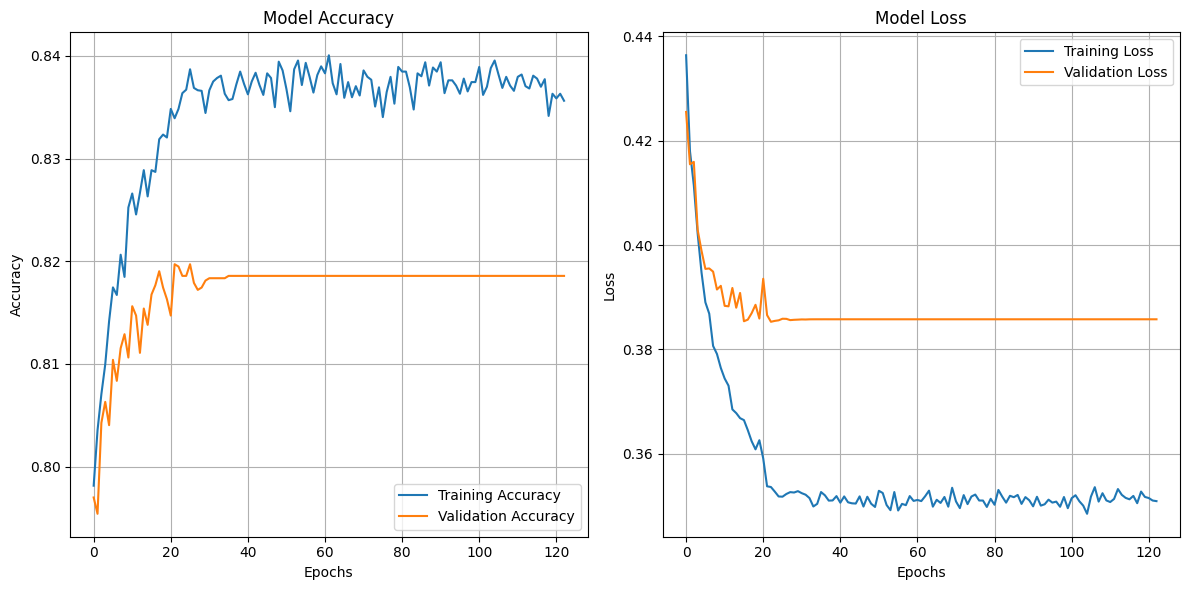

In [75]:
selected_features = selected_features_original
aux_features = ['num__p0', 'num__p1', 'num__p2']
for aux_feat in aux_features:
    if aux_feat in feature_names and aux_feat not in selected_features:
        selected_features.append(aux_feat)
    
# Prepare the data with selected features
selected_indices = [list(feature_names).index(feat) for feat in selected_features]
    
# Transform the entire dataset again
X_second_processed_full = preprocessor_second.transform(data[second_stage_features])
X_final = X_second_processed_full[:, selected_indices]
    
# Split the data
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final,
    y_second,
    test_size=0.2,
    random_state=77
)

# Build the model with the best hyperparameters
model = build_model(best_hps)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Retrain the model and capture the history
history = model.fit(
    X_train_final,
    y_train_final,
    epochs=500,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
    
# Evaluate the model
loss, accuracy = model.evaluate(X_test_final, y_test_final, verbose=0)
    
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test_final).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Now you can plot the training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()



Optimal Threshold (Highest Test Accuracy): 0.57
Test Accuracy at Optimal Threshold: 0.8229
              precision    recall  f1-score   support

    Survived       0.83      0.96      0.89      4154
        Died       0.76      0.41      0.53      1350

    accuracy                           0.82      5504
   macro avg       0.80      0.68      0.71      5504
weighted avg       0.81      0.82      0.80      5504



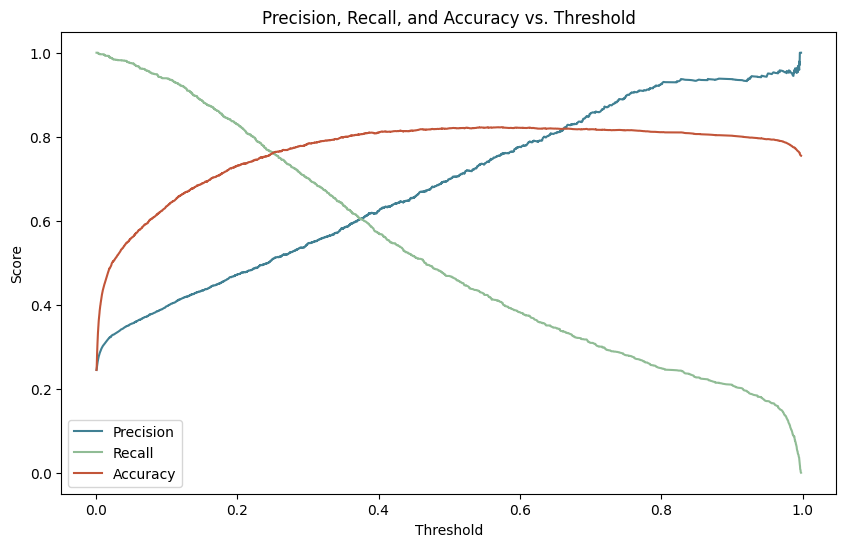

In [76]:
from sklearn.metrics import accuracy_score, precision_recall_curve
from math import floor
# Compute precision-recall pairs and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_final, y_pred_probs)

# Compute accuracy for each threshold
accuracies = []
for threshold in thresholds:
    y_pred = (y_pred_probs >= threshold).astype(int)
    accuracies.append(accuracy_score(y_test_final, y_pred))

# Find the optimal threshold based on maximum test accuracy
optimal_idx = np.argmax(accuracies)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (Highest Test Accuracy): {optimal_threshold:.2f}")
print(f"Test Accuracy at Optimal Threshold: {accuracies[optimal_idx]:.4f}")

# Use the optimal threshold for predictions
y_pred = (y_pred_probs >= optimal_threshold).astype(int)

# Print classification report
print(classification_report(y_test_final, y_pred, target_names=['Survived', 'Died']))

# Plot precision, recall, and accuracy vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color = hex_palette[1])
plt.plot(thresholds, recall[:-1], label='Recall', color = color_palette[3])
plt.plot(thresholds, accuracies, label='Accuracy', color = hex_palette[len(hex_palette)-1])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()


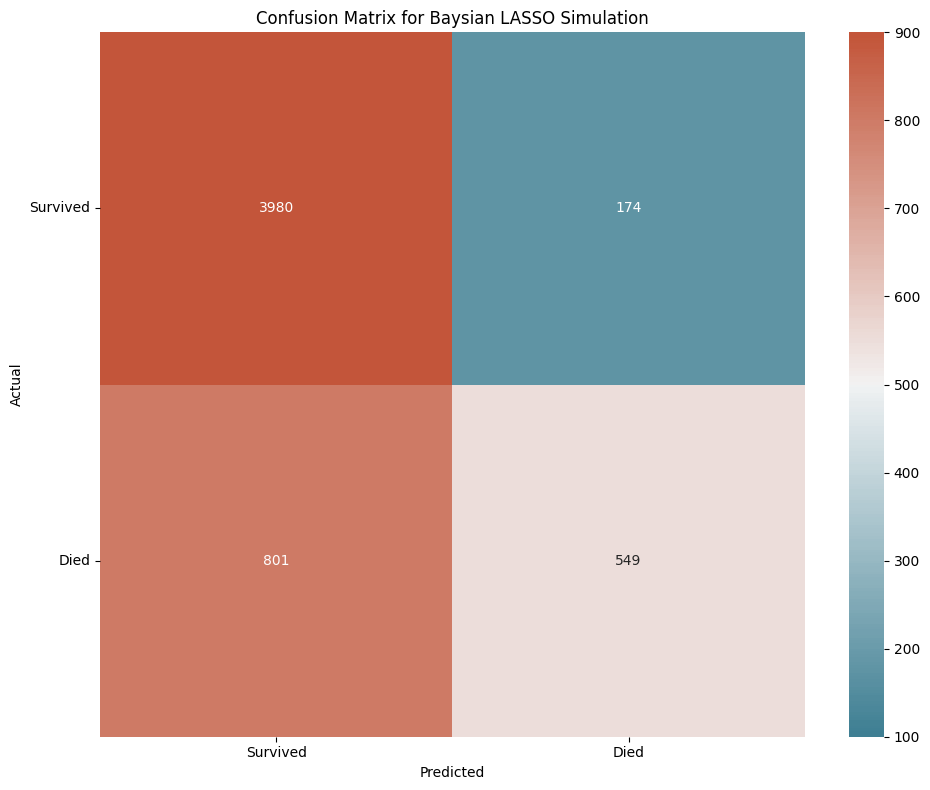

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test_final, y_pred)
plot_confusion_matrix(cm, vmax=900, vmin=100, title="Confusion Matrix for Baysian LASSO Simulation")

In [61]:
# Predict on the entire dataset
y_pred_probs_full = model.predict(X_final).flatten()
y_pred_full = (y_pred_probs_full >= 0.5).astype(int)

# Append predictions to the original dataset
data_with_predictions = data.copy()
data_with_predictions['predicted_mortality_probability'] = y_pred_probs_full
data_with_predictions['predicted_mortality'] = y_pred_full

# Save the updated dataset
data_with_predictions.to_csv('BaysianLASSO_real_data_with_mortality_predictions.csv', index=False)

860/860 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


## Evaluation

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Assuming binary classification and y_test_final, y_pred, y_pred_probs are known
precision_nn = precision_score(y_test_final, y_pred)
recall_nn = recall_score(y_test_final, y_pred)
f1_nn = f1_score(y_test_final, y_pred)
auc_nn = roc_auc_score(y_test_final, y_pred_probs)

print("Bayesian LASSO Neural Network Metrics:")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1 Score: {f1_nn:.4f}")
print(f"AUC: {auc_nn:.4f}")


Bayesian LASSO Neural Network Metrics:
Precision: 0.7593
Recall: 0.4067
F1 Score: 0.5297
AUC: 0.8557


In [79]:
import numpy as np

# Spike NN Metrics
precision_spike = 0.7235
recall_spike = 0.4496
f1_spike = 0.5546
auc_spike = 0.8531

# LASSO NN Metrics
precision_lasso = 0.7479
recall_lasso = 0.3252
f1_lasso = 0.4533
auc_lasso = 0.8316

# Bayesian LASSO NN Metrics
precision_blasso = 0.7593
recall_blasso = 0.4067
f1_blasso = 0.5297
auc_blasso = 0.8557

def improvement(new, old):
    return ((new - old) / old) * 100

# Compare Spike to LASSO
print("Spike vs LASSO Precision Improvement:", improvement(precision_spike, precision_lasso), "%")
print("Spike vs LASSO Recall Improvement:", improvement(recall_spike, recall_lasso), "%")
print("Spike vs LASSO F1 Improvement:", improvement(f1_spike, f1_lasso), "%")
print("Spike vs LASSO AUC Improvement:", improvement(auc_spike, auc_lasso), "%")

# Compare Bayesian LASSO to LASSO
print("Bayesian LASSO vs LASSO Precision Improvement:", improvement(precision_blasso, precision_lasso), "%")
print("Bayesian LASSO vs LASSO Recall Improvement:", improvement(recall_blasso, recall_lasso), "%")
print("Bayesian LASSO vs LASSO F1 Improvement:", improvement(f1_blasso, f1_lasso), "%")
print("Bayesian LASSO vs LASSO AUC Improvement:", improvement(auc_blasso, auc_lasso), "%")

# Compare Spike to Bayesian LASSO
print("Spike vs Bayesian LASSO Precision Improvement:", improvement(precision_spike, precision_blasso), "%")
print("Spike vs Bayesian LASSO Recall Improvement:", improvement(recall_spike, recall_blasso), "%")
print("Spike vs Bayesian LASSO F1 Improvement:", improvement(f1_spike, f1_blasso), "%")
print("Spike vs Bayesian LASSO AUC Improvement:", improvement(auc_spike, auc_blasso), "%")


Spike vs LASSO Precision Improvement: -3.2624682444176996 %
Spike vs LASSO Recall Improvement: 38.253382533825345 %
Spike vs LASSO F1 Improvement: 22.347231414074564 %
Spike vs LASSO AUC Improvement: 2.585377585377581 %
Bayesian LASSO vs LASSO Precision Improvement: 1.5242679502607255 %
Bayesian LASSO vs LASSO Recall Improvement: 25.061500615006153 %
Bayesian LASSO vs LASSO F1 Improvement: 16.85418045444517 %
Bayesian LASSO vs LASSO AUC Improvement: 2.898027898027899 %
Spike vs Bayesian LASSO Precision Improvement: -4.714868958251013 %
Spike vs Bayesian LASSO Recall Improvement: 10.548315711826897 %
Spike vs Bayesian LASSO F1 Improvement: 4.7007740230319115 %
Spike vs Bayesian LASSO AUC Improvement: -0.3038448054224666 %
